In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/archive.zip','r') #Opens the zip file
zip_ref.extractall('/tmp')  #Extracts the files into the /tmp folder
zip_ref.close()

In [4]:
# Import all the necessary Library
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

In [5]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [6]:
import os

path = "/tmp/sign_data"
files = os.listdir(path)

for f in files:
    print(f)

sign_data
train
test
test_data.csv
train_data.csv


In [7]:
class Config():
    training_dir = "/tmp/sign_data/train"
    testing_dir = "/tmp/sign_data/test"
    train_batch_size = 32
    train_number_epochs = 20

In [8]:
training_dir="/tmp/sign_data/train"
training_csv="/tmp/sign_data/train_data.csv"
testing_csv="/tmp/sign_data/test_data.csv"
testing_dir="/tmp/sign_data/test"

In [9]:
class SiameseNetworkDataset():

    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir
        self.transform = transform

    def __getitem__(self,index):

        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])


        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))

    def __len__(self):
        return len(self.training_df)

In [10]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

In [11]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())

2.6.0+cu124
0.21.0+cu124
True


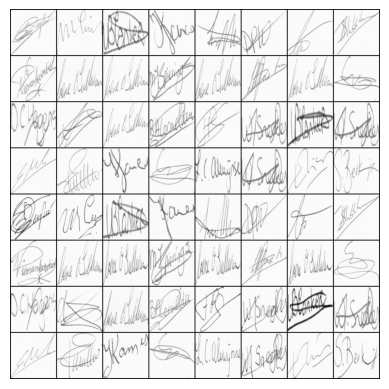

[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [12]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=32)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [13]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(

            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128,2))



    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [14]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [15]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=32, num_workers=0)

In [16]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')
else:
    print('GPU not availble')

Yes


In [17]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [18]:
def train():
    counter = []
    loss_history = []
    iteration_number= 0

    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [19]:
# Modified/Updated the training code
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the model
def train():
    counter = []
    loss_history = []
    iteration_number = 0

    for epoch in range(0, Config.train_number_epochs):
        correct = 0
        total = 0
        for i, data in enumerate(train_dataloader, 0):
            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

            # Calculate Euclidean distance
            distance = torch.norm(output1 - output2, dim=1)
            # Predict: similar (0) if distance < 0.5
            pred = (distance > 0.5).float()
            correct += (pred == label).sum().item()
            total += label.size(0)

            if i % 50 == 0:
                print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{Config.train_number_epochs} - Training Accuracy: {accuracy:.2f}%")

    return net

model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

Epoch number 0
 Current loss 1.7434031963348389

Epoch number 0
 Current loss 1.1559494733810425

Epoch number 0
 Current loss 0.9546160101890564

Epoch number 0
 Current loss 1.2480156421661377

Epoch number 0
 Current loss 1.2085227966308594

Epoch number 0
 Current loss 1.3358540534973145

Epoch number 0
 Current loss 1.089625597000122

Epoch number 0
 Current loss 1.2131588459014893

Epoch number 0
 Current loss 1.5832099914550781

Epoch number 0
 Current loss 1.3129870891571045

Epoch number 0
 Current loss 1.4348995685577393

Epoch number 0
 Current loss 1.250458836555481

Epoch number 0
 Current loss 1.198429822921753

Epoch number 0
 Current loss 1.23674476146698

Epoch number 0
 Current loss 1.3327903747558594

Epoch 1/20 - Training Accuracy: 1564.18%
Epoch number 1
 Current loss 1.260070562362671

Epoch number 1
 Current loss 1.2806670665740967

Epoch number 1
 Current loss 0.9444091320037842

Epoch number 1
 Current loss 1.1746171712875366

Epoch number 1
 Current loss 1.356

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

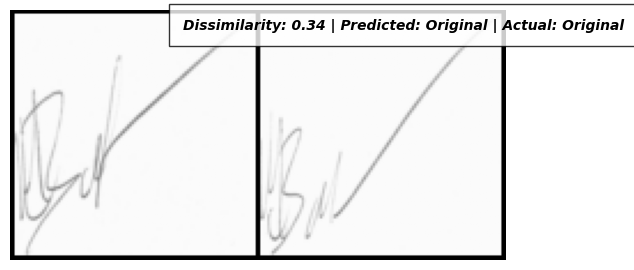

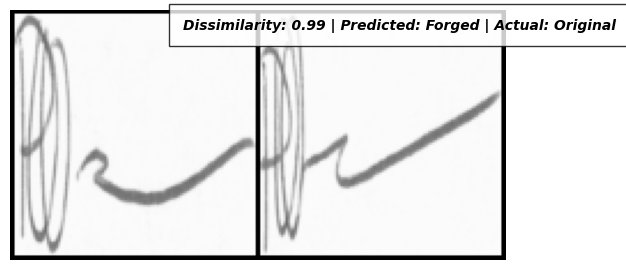

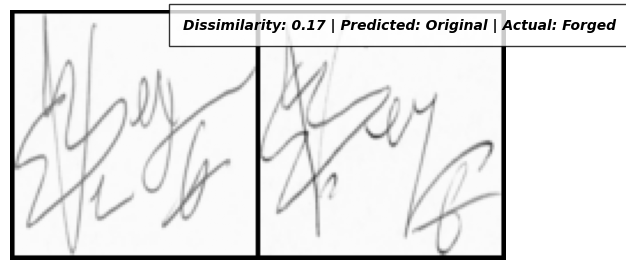

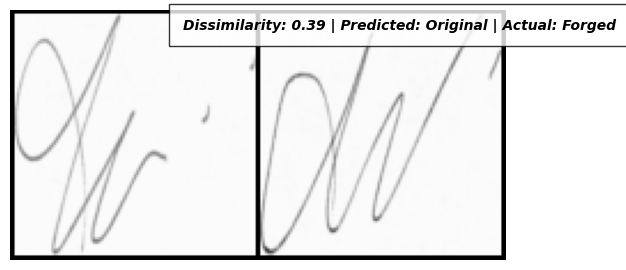

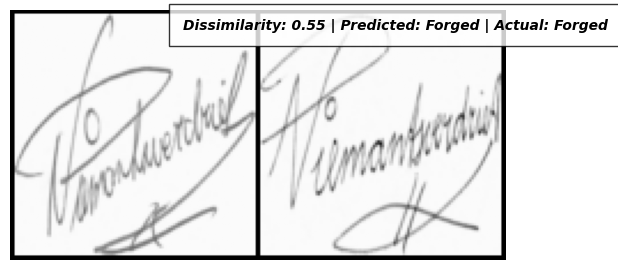

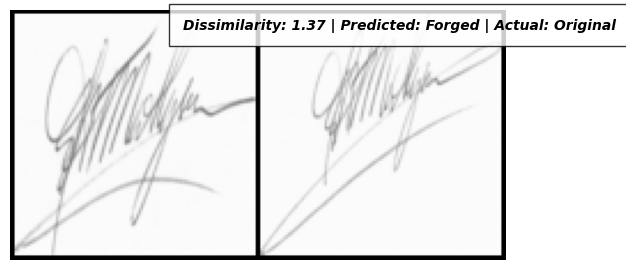

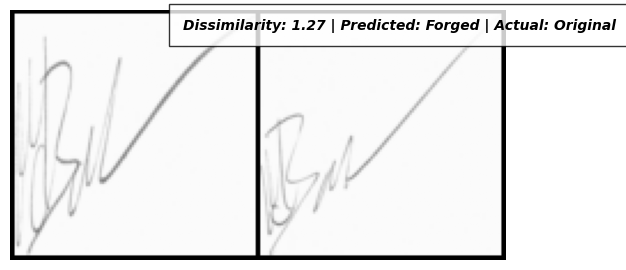

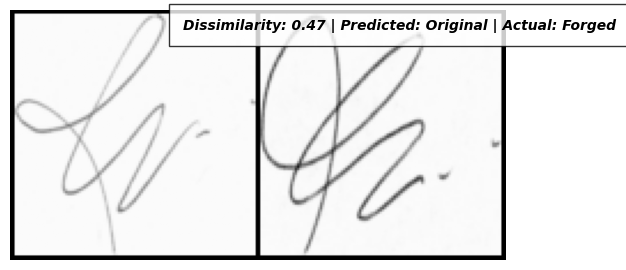

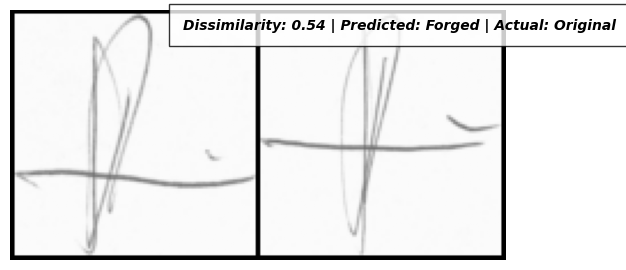

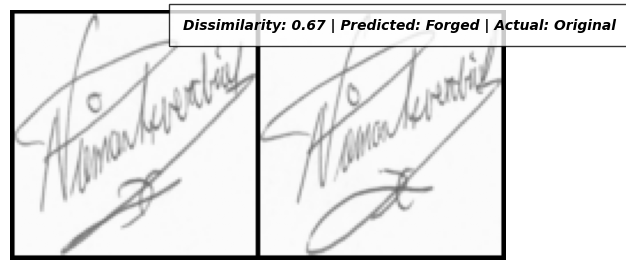

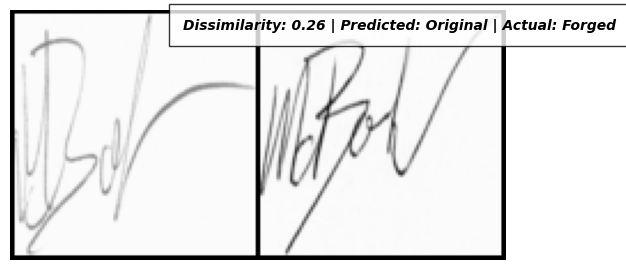

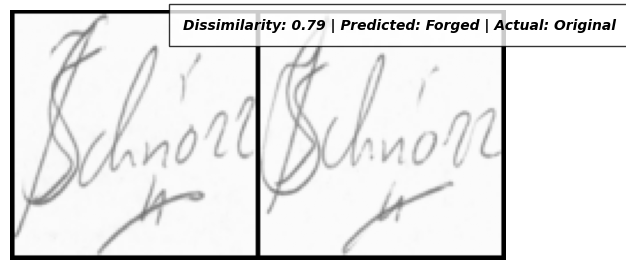

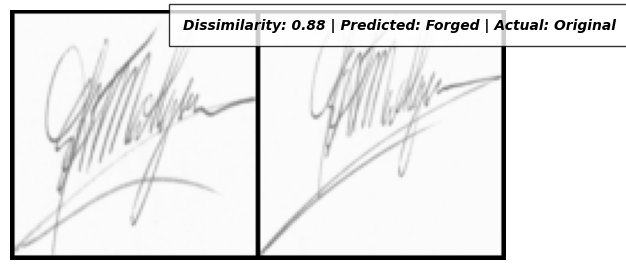

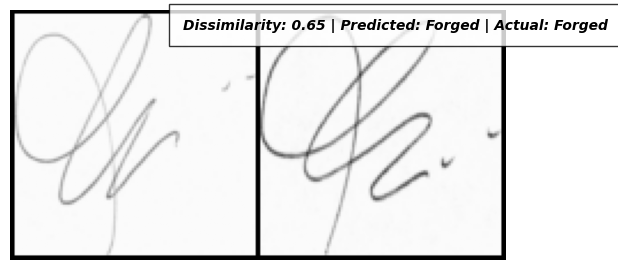

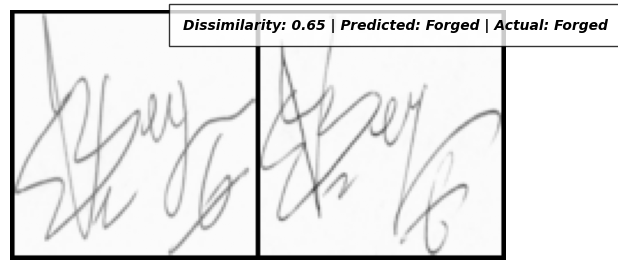

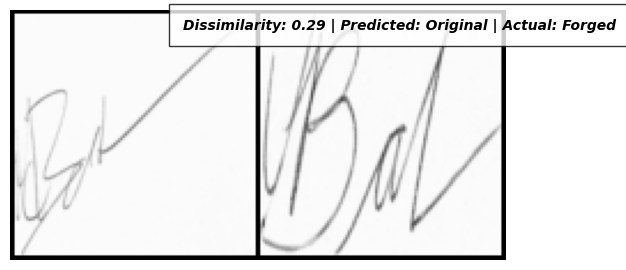

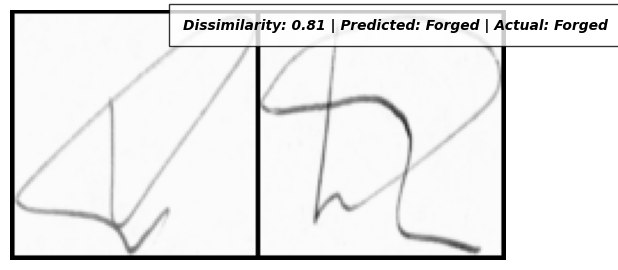

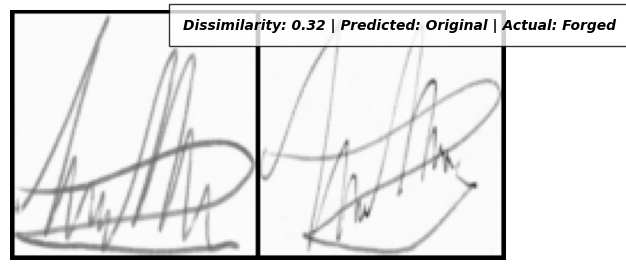

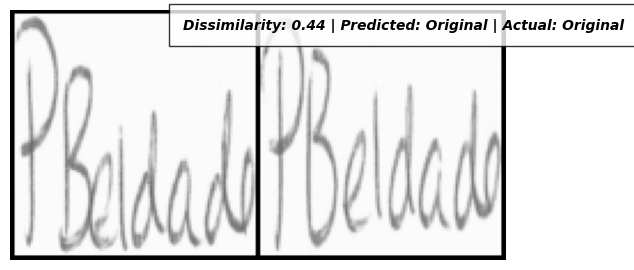

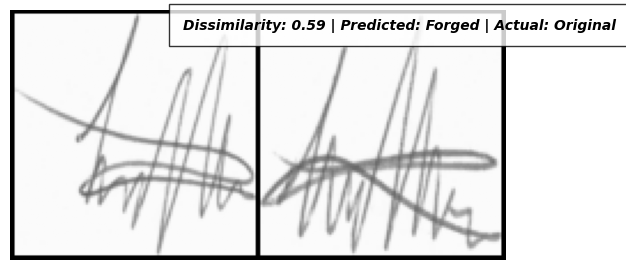

Test Accuracy: 30.00%


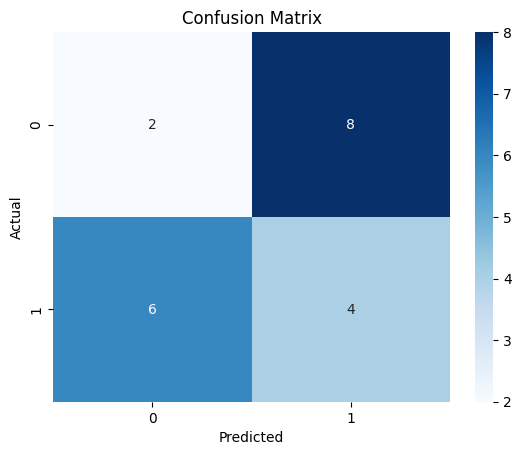

In [21]:
# Modified/Updated the testing code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)

# Load model weights safely
state_dict = torch.load("model.pt", weights_only=True)
model.load_state_dict(state_dict)

# Load the test dataset
test_dataset = SiameseNetworkDataset(
    training_csv=testing_csv,
    training_dir=testing_dir,
    transform=transforms.Compose([
        transforms.Resize((105, 105)),
        transforms.ToTensor()
    ])
)

test_dataloader = DataLoader(test_dataset, num_workers=0, batch_size=1, shuffle=True)

# Set your distance threshold
threshold = 0.5  # Adjust this based on validation experiments

y_true = []
y_pred = []
counter = 0

with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        x0, x1, label = data
        concatenated = torch.cat((x0, x1), 0)

        # Pass through model
        output1, output2 = model(x0.to(device), x1.to(device))
        eucledian_distance = F.pairwise_distance(output1, output2)

        # Prediction based on distance
        if eucledian_distance.item() < threshold:
            predicted_label = "Original"
        else:
            predicted_label = "Forged"

        #Ground-truth label
        if label.item() == 0:
            actual_label = "Original"
        else:
            actual_label = "Forged"

        # Display the images and labels
        imshow(
            torchvision.utils.make_grid(concatenated),
            'Dissimilarity: {:.2f} | Predicted: {} | Actual: {}'.format(
                eucledian_distance.item(), predicted_label, actual_label
            )
        )

        y_true.append(0 if actual_label == "Original" else 1)
        y_pred.append(0 if predicted_label == "Original" else 1)

        counter += 1
        if counter == 20:
            break

# Compute and print accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()